# Install, Paths and Parameters

In [1]:
import os
from pathlib import Path
import getpass
import numpy as np
import time
import torch
from torch import nn
from tqdm import tqdm
import random
import sys

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino, ViTWrapper
from src.model.data import create_loader
from src.model.eval import validate_network

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

username = getpass.getuser()
DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')

ORI_PATH = Path(DATA_PATH, 'ori_data/validation')
ORI_LABEL_PATH = Path(ORI_PATH,'correct_labels.txt')
ORI_IMAGES_PATH = Path(ORI_PATH,'images')

DN_PATH = Path(DATA_PATH, 'adversarial_data')
DN_LABEL_PATH = Path(ORI_PATH,'correct_labels.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'pgd_03/validation/images/')

In [2]:
# If CLASS_SUBSET is specified, INDEX_SUBSET will be ignored. Set CLASS_SUBSET=None if you want to use indexes.
INDEX_SUBSET = get_random_indexes()
CLASS_SUBSET = get_random_classes(number_of_classes=10, seed=1)

BATCH_SIZE = 100

DEVICE = 'cuda'

In [3]:
CLASS_SUBSET

array([ 37, 235, 908,  72, 767, 905, 715, 645, 847, 960])

In [4]:
#!python $HOME/deeplearning/setup/collect_env.py

# Import DINO
Official repo: https://github.com/facebookresearch/dino

In [5]:
model, linear_classifier = get_dino()

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_small built.
Embed dim 1536
We load the reference pretrained linear weights from dino_deitsmall16_pretrain/dino_deitsmall16_linearweights.pth.


# Load data

In [6]:
org_loader = create_loader(ORI_IMAGES_PATH, ORI_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE)

In [16]:
from torchvision import transforms as pth_transforms

loader_transform = pth_transforms.Compose([
            pth_transforms.ToTensor()
        ])

In [17]:
adv_loader = create_loader(DN_IMAGES_PATH, DN_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE, transform = loader_transform)

## Wrap model

In [8]:
model_wrap = ViTWrapper(model, linear_classifier, DEVICE, n_last_blocks=4, avgpool_patchtokens=False)
model_wrap= model_wrap.to(DEVICE)

# Generate input to linear layer

### Adversarial images

In [18]:
result = None
img_labels = None
imgs = None
correct = 0

with torch.no_grad():
    for images, labels, names in tqdm(adv_loader):
        x = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # forward
        intermediate_output = model_wrap.vits16.get_intermediate_layers(x, model_wrap.n_last_blocks)
        output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)
        if model_wrap.avgpool_patchtokens:
            output = torch.cat((output.unsqueeze(-1), torch.mean(intermediate_output[-1][:, 1:], dim=1).unsqueeze(-1)), dim=-1)
            output = output.reshape(output.shape[0], -1)
        
        if result is None:
            result = output
            img_labels = labels
            imgs = images
        else:
            result = torch.cat([result, output], 0)
            img_labels = torch.cat([img_labels, labels])
            imgs = torch.cat([imgs, images], 0)
        
        outputs = model_wrap.linear_layer(output)

        _, pre = torch.max(outputs.data, 1)

        correct += (pre == labels).sum()

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


In [19]:
correct

tensor(2, device='cuda:0')

### Original images

In [25]:
org_result = None
org_img_labels = None
correct = 0

with torch.no_grad():
    for images, labels in tqdm(org_loader):
        x = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # forward
        intermediate_output = model_wrap.vits16.get_intermediate_layers(x, model_wrap.n_last_blocks)
        output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)
        if model_wrap.avgpool_patchtokens:
            output = torch.cat((output.unsqueeze(-1), torch.mean(intermediate_output[-1][:, 1:], dim=1).unsqueeze(-1)), dim=-1)
            output = output.reshape(output.shape[0], -1)
        
        if org_result is None:
            org_result = output
            org_img_labels = labels
        else:
            org_result = torch.cat([org_result, output], 0)
            org_img_labels = torch.cat([org_img_labels, labels])
            
        outputs = model_wrap.linear_layer(output)

        _, pre = torch.max(outputs.data, 1)

        correct += (pre == labels).sum()

100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


In [26]:
correct

tensor(370, device='cuda:0')

In [82]:
# Map classes
map_dict = {}
inv_map_dict = {}
labels = img_labels.numpy()
i = 0

for l in labels:
    if l not in map_dict:
        map_dict[l] = i
        inv_map_dict[i] = l
        i = i+1

In [83]:
map_dict

{645: 0, 37: 1, 767: 2, 905: 3, 960: 4, 715: 5, 235: 6, 72: 7, 908: 8, 847: 9}

In [84]:
mapped_labels = [map_dict[i] for i in labels]
org_mapped_labels = [map_dict[i] for i in org_img_labels.numpy()]

# UMAP

In [69]:
import umap
import matplotlib.pyplot as plt

In [70]:
reducer = umap.UMAP(random_state=SEED, n_neighbors = 250)

In [85]:
combined = torch.cat([result, org_result], 0)
combined_labels = mapped_labels+org_mapped_labels

In [72]:
reducer.fit(combined.cpu().numpy())

UMAP(n_neighbors=250, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [73]:
embedding = reducer.transform(combined.cpu().numpy())

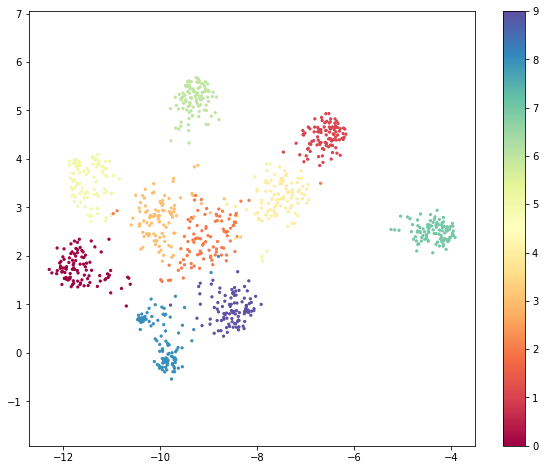

In [86]:
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(embedding[:, 0], embedding[:, 1], c=combined_labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()

In [87]:
# Fancy plot
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Legend
from bokeh.palettes import Spectral10, Category10
import pandas as pd
from io import BytesIO
from PIL import Image
import base64

output_notebook()

Loading BokehJS ...

In [90]:
df = pd.DataFrame(embedding, columns=('x', 'y'))
df['label'] = [str(x) for x in combined_labels]
#df = pd.read_csv('df.csv', index_col=0)
df['label'] = [str(x) for x in df.label]
df['true_label'] = df['label'].values
df['true_label'] = df['true_label'].astype(int).replace(inv_map_dict)

datasource = ColumnDataSource(df)
color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in [i for i in range(10)]],
                                       palette=Category10[10])

plot_figure = figure(
    title='',
    plot_width=600,
    plot_height=400,
    tools=('pan, wheel_zoom, reset, save')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 16px; color: #224499'>Label:</span>
        <span style='font-size: 18px'>@true_label</span>
    </div>
</div>
"""))

plot_figure.add_layout(Legend(), 'right')

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='label', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=6,
    legend_field='true_label'
)

plot_figure.xaxis.visible = False
plot_figure.xgrid.visible = False
plot_figure.yaxis.visible = False
plot_figure.ygrid.visible = False

plot_figure.outline_line_width = 2
plot_figure.outline_line_alpha = 0.8
plot_figure.outline_line_color = "gray"

plot_figure.legend.location = "center"
plot_figure.legend.title = 'True class'
plot_figure.legend.title_text_font_style = "bold"
plot_figure.legend.title_text_font_size = "14px"

show(plot_figure)